In [19]:
import pandas as pd
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#!pip install unidecode
#!pip install datasketch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import unidecode
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
from collections import Counter
import random
from datasketch import MinHash, MinHashLSH

In [64]:
def measure_metrics(true_labels, predicted_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(true_labels)):
        golden = str(true_labels[i]).split(", ")
        predicted = str(predicted_labels[i]).split(", ")
        if len(golden) == 1 and len(predicted) == 1 and predicted == golden:
            tn += 1
        elif golden == predicted:
            tp += 1
        elif len(predicted) > len(golden):
            fp += 1
        else:
            fn += 1
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1score = 2*tp / (2*tp + fp + fn)
    return accuracy, precision, recall, f1score



def measure_metrics2(true_labels, predicted_labels):
    pre = []
    rec = []
    f1 = []

    for i in range(len(true_labels)):
        tp = 0
        fp = 0
        fn = 0
        
        golden = str(true_labels[i]).split(", ")
        predicted = str(predicted_labels[i]).split(", ")
        
        # Check if there is an intersection before attempting to remove elements
        intersection = list(set(golden).intersection(set(predicted)))
        if intersection:
            to_remove = intersection[0]
            golden.remove(to_remove)
            predicted.remove(to_remove)
        
        if golden or predicted:
            for j in golden:
                if j in predicted:
                    tp += 1
                else:
                    fn += 1

            for j in predicted:
                if j not in golden:
                    fp += 1

            if tp + fp == 0:
                precision = 0
            else:
                precision = tp / (tp + fp)

            if tp + fn == 0:
                recall = 0
            else:
                recall = tp / (tp + fn)

            if precision + recall == 0:
                f1score = 0
            else:
                f1score = 2 * (precision * recall) / (precision + recall)
                
            pre.append(precision)
            rec.append(recall)
            f1.append(f1score)

    return np.mean(pre), np.mean(rec), np.mean(f1)

def measure_metrics3(true_labels, predicted_labels):
    tp = 0
    fp = 0
    fn = 0
    
    for i in range(len(true_labels)):  
        golden = str(true_labels[i]).split(", ")
        predicted = str(predicted_labels[i]).split(", ")
        
        # Check if there is an intersection before attempting to remove elements
        intersection = list(set(golden).intersection(set(predicted)))
        if intersection:
            to_remove = intersection[0]
            golden.remove(to_remove)
            predicted.remove(to_remove)
        
        if golden or predicted:
            for j in golden:
                if j in predicted:
                    tp += 1
                else:
                    fn += 1

            for j in predicted:
                if j not in golden:
                    fp += 1

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1score = 0
    else:
        f1score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1score


def replace_non_letters(input_string):
    return re.sub(r"[^a-zA-Z\s]", " ", input_string)

def unidecoded(panda_column):
    return panda_column.astype(str).apply(
        lambda x: unidecode.unidecode(
            x.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')
             .replace('Ä', 'Ae').replace('Ö', 'Oe').replace('Ü', 'Ue')))


In [65]:
def generate_emails(first_name, last_name):
    # Diese Funktion erzeugt eine Liste von E-Mail-Adressen basierend auf Vor- und Nachnamen
    # Diese Liste enthält verschiedene Formate wie Vorname.Nachname, VNach, Vorname usw.
    emails = []
    emails.append(f"{first_name.lower()}.{last_name.lower()}")
    emails.append(f"{first_name.lower()[0]}{last_name.lower()}")
    emails.append(f"{first_name.lower()}")
    emails.append(f"{first_name.lower()[0]}.{last_name.lower()}")
    emails.append("anderes")
    emails.append("info")
    emails.append(f"{last_name.lower()}")
    emails.append(f"{first_name.lower()}{last_name.lower()}")
    emails.append(f"{first_name.lower()}.{last_name.lower()}1990")  # Vor.NachnameJahr
    return emails

def fake_emails(first_name, last_name):
    # Diese Funktion generiert eine E-Mail-Adresse basierend auf den gegebenen Wahrscheinlichkeiten
    distr = {
        "vor.nach": 55/100,
        "vnach": 10/100,
        "vor": 9/100,
        "v.nach": 6/100,
        "anderes": 6/100,
        "info": 5/100,
        "nach": 4/100,
        "vornach": 3/100,
        "vor.nachjahr": 2/100
    }
    
    # Generiere eine Liste von E-Mail-Adressen
    emails = generate_emails(first_name, last_name)
    
    # Wähle zufällig eine E-Mail-Adresse basierend auf den Wahrscheinlichkeiten aus
    random_percentage = random.random()
    total = 0
    i = 0
    for scenario, percentage in distr.items():
        total += percentage
        if random_percentage <= total:

            return emails[i]  # Gib die E-Mail-Adresse zurück
        else:
            i += 1

def plausible_email(first_name, last_name, email):
    email = email.split("@")[0]
    email = re.sub(r'\d+', '', email)
    plausible_formats = [
        f"{first_name.lower()}.{last_name.lower()}",
        f"{first_name.lower()}{last_name.lower()}",
        f"{first_name.lower()[0]}{last_name.lower()}",
        f"{first_name.lower()}",
        f"{first_name.lower()[0]}.{last_name.lower()}",
        f"{last_name.lower()}",
    ]
    
    if first_name and last_name in email:
        return True
    else:
        return email in plausible_formats

# Beispielvor- und nachname
first_name = "Max"
last_name = "Mustermann"

df = pd.read_excel("Testcases.xlsx")

for vor, nach, email in zip(unidecoded(df["Vorname"]).to_list(), unidecoded(df["Nachname"]).to_list(), unidecoded(df["Email"]).to_list()):
    res = plausible_email(vor, nach, email)
    print(res)
    # Generiere eine E-Mail-Adresse basierend auf den Wahrscheinlichkeiten
    #generated_email = fake_emails(unidecode(str(vor)), unidecode(str(nach)))

    # Ausgabe der generierten E-Mail-Adresse
    #print(generated_email)


True
True
True
True
True
False
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
False
True
False
True
False
True
False
False
False
True
False
True
False
True
False
False
True
True
True
False
False
True
False
False
False
False
True
False
False
True
True
False
False
True
True
True
True
False
False
False
True
True
False
False
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
T

In [66]:

df = pd.read_excel("Alle_Dubletten_geprüft.xlsx")

vorname_count = unidecoded(df["Vorname"]).str.lower().value_counts()
nachname_count = unidecoded(df["Nachname"]).str.lower().value_counts()

top_20_vornamen = vorname_count.head(21)
top_20_nachnamen = nachname_count.head(21)

two_to_five_occ = vorname_count[(vorname_count >= 2) & (vorname_count <= 5)]

print(top_20_vornamen, top_20_nachnamen)

def count_dup_top_20(name_col: List[str], dup_col: List[str]) -> Dict:
    name_col = [unidecode(str(string)) for string in name_col]
    name_dict = {}
    
    for i, name in enumerate(name_col):
        if name != "nan" and len(dup_col[i].split(", ")) > 1 and (name.lower() in top_20_vornamen or name.lower() in top_20_nachnamen):
            if name.capitalize() not in name_dict:
                name_dict[name.capitalize()] = 1
            else:
                name_dict[name.capitalize()] += 1
    sorted_dict = dict(sorted(name_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict



def count_dup_rare(name_col: List[str], dup_col: List[str]) -> Dict:
    name_col = [unidecode(str(string)) for string in name_col]
    name_dict = {}
    
    for i, name in enumerate(name_col):
        if name != "nan" and len(dup_col[i].split(", ")) > 1 and name.lower() in two_to_five_occ:
            if name.capitalize() not in name_dict:
                name_dict[name.capitalize()] = 1
            else:
                name_dict[name.capitalize()] += 1
    sorted_dict = dict(sorted(name_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict


def factor_count_dup_rare(name_col: List[str], dup_col: List[str]) -> int:
    dup_dict = count_dup_rare(name_col, dup_col)
    count_dict = two_to_five_occ.to_dict()
    
    if "nan" in count_dict:
        del count_dict["nan"]
    print(count_dict)
    return sum(dup_dict.values()) / sum(count_dict.values())
    

Vorname
nan          3587
thomas        505
daniel        444
andreas       380
martin        351
markus        347
peter         340
stefan        317
christian     313
michael       306
patrick       219
urs           213
marco         204
christoph     200
marcel        175
roland        171
marc          166
matthias      158
beat          158
reto          152
adrian        149
Name: count, dtype: int64 Nachname
nan           3477
mueller        171
meier          114
schmid          78
meyer           75
keller          75
schneider       65
zentrale        65
fischer         59
huber           58
widmer          54
weber           54
zimmermann      48
steiner         44
brunner         43
roth            43
frei            42
berger          40
baumann         40
graf            39
gerber          39
Name: count, dtype: int64


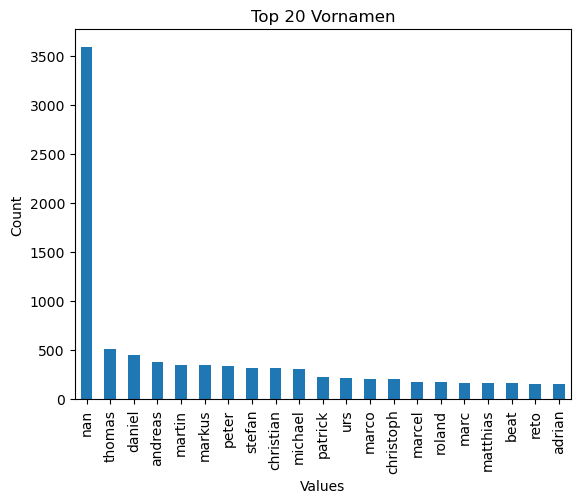

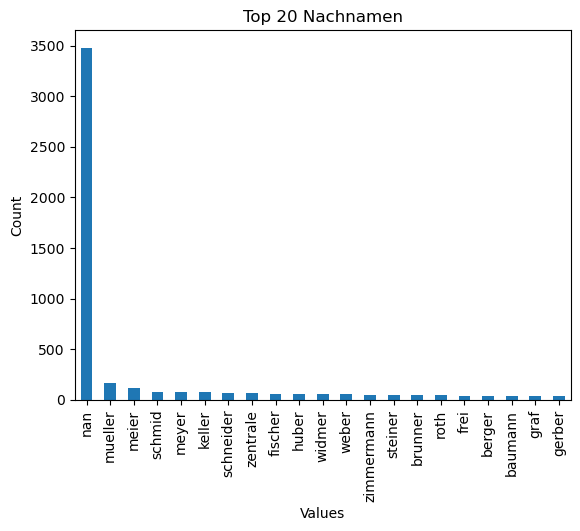

In [67]:
top_20_vornamen.plot(kind="bar")
plt.title("Top 20 Vornamen")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

top_20_nachnamen.plot(kind="bar")
plt.title("Top 20 Nachnamen")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

In [68]:
df = pd.read_excel("Testcases.xlsx")

#replace Umlaute
df["Vorname"] = df['Vorname'].str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue').str.replace('Ä', 'Ae').str.replace('Ö', 'Oe').str.replace('Ü', 'Ue')
df["Nachname"] = df['Nachname'].str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue').str.replace('Ä', 'Ae').str.replace('Ö', 'Oe').str.replace('Ü', 'Ue')

def simple(full_name):
    namen = {}

    for index, name in full_name.items():
        if name == "":
            continue

        if name in namen:
            namen[name].append(int(df.at[index, "ID"]))
        else:
            namen[name] = [int(df.at[index, "ID"])]

    df["Simple Match"] = str(0)
    for n in namen:
        for m in namen[n]:
            df.at[m-1, "Simple Match"] = str(namen[n])[1:-1]


    sorted_dict = dict(sorted(namen.items(), key=lambda item: item[1], reverse=True))

In [69]:
import unidecode
import pandas as pd

def soundex(full_name):
    soundex_mapping = {
        "a": "0", "e": "0", "i": "0", "o": "0", "u": "0", "ä": "0", "ö": "0", "ü": "0", "y": "0", "j": "0", "h": "0",
        "b": "1", "p": "1", "f": "1", "v": "1", "w": "1",
        "c": "2", "s": "2", "k": "2", "g": "2", "q": "2", "x": "2", "z": "2", "ß": "2",
        "d": "3", "t": "3",
        "l": "4",
        "m": "5", "n": "5",
        "r": "6",
        "ch": "7", "sch": "7", "sh": "7",
        "-": " "
    }

    soundex_codes = {}

    for index, name in full_name.items():
        if name == "":
            continue

        name = name.lower()
        name = name.replace("sch", "7").replace("ch", "7").replace("sh", "7")

        soundex_code = name[0].upper()

        previous_digit = ""
        for letter in name[1:]:
            if letter in soundex_mapping:
                current_digit = soundex_mapping[letter]
                if current_digit != previous_digit and current_digit != '0':
                    soundex_code += current_digit
                    previous_digit = current_digit

        soundex_code = soundex_code[:4]

        while len(soundex_code) < 4:
            soundex_code += '0' 
        if soundex_code in soundex_codes:
            soundex_codes[soundex_code].append(index+1)
        else:
            soundex_codes[soundex_code] = [index+1]
            
    df["Soundex"] = str(0)
    
    for n in soundex_codes:
        for m in soundex_codes[n]:
            df.at[m-1, "Soundex"] = str(soundex_codes[n])[1:-1]



In [70]:
#Soundex representation
df = pd.read_excel("Testcases.xlsx")

def soundex_custom(full_name):
    soundex_mapping = {
            "a": "0", "e": "0", "i": "0", "o": "0", "u": "0", "ä": "0", "ö": "0", "ü": "0", "y": "0", "j": "0", "h": "0",
            "b": "1", "p": "1", "f": "1", "v": "1", "w": "1",
            "c": "2", "s": "2", "k": "2", "g": "2", "q": "2", "x": "2", "z": "2", "ß": "2",
            "d": "3", "t": "3",
            "l": "4",
            "m": "5", "n": "5",
            "r": "6",
            "ch": "7", "sch": "7",
            "-": " "
        }

    soundex_namen = {}

    for index, name in full_name.items():

        if name == "" or pd.isna(name):
            continue

        name = str(name).replace("sch", "7").replace("ch", "7").replace("sh", "7")

        soundex_name = ""
        soundex_name += name[0]

        for letter in name.lower()[1:]:
            if letter in soundex_mapping and soundex_mapping[letter] != soundex_name[-1]:
                soundex_name += soundex_mapping[letter]

            elif letter not in soundex_mapping:
                soundex_name += letter
                
        if soundex_name in soundex_namen:
            soundex_namen[soundex_name].append(int(df.at[index, "ID"]))
        else:
            soundex_namen[soundex_name] = [int(df.at[index, "ID"])]

    df["Soundex Custom"] = str(0)
    for n in soundex_namen:
        for m in soundex_namen[n]:
            df.at[m-1, "Soundex Custom"] = str(soundex_namen[n])[1:-1]
        

In [71]:
def levenshteinDistance(A, B):
    N, M = len(A), len(B)
    
    dp = [[0 for i in range(M + 1)] for j in range(N + 1)]

    for j in range(M + 1):
        dp[0][j] = j
        
    for i in range(N + 1):
        dp[i][0] = i
        
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if A[i - 1] == B[j - 1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(
                    dp[i-1][j],
                    dp[i][j-1],
                    dp[i-1][j-1]
                )

    return dp[N][M]

In [72]:
#replace Umlaute

df["Vorname"] = df['Vorname'].str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue').str.replace('Ä', 'Ae').str.replace('Ö', 'Oe').str.replace('Ü', 'Ue')
df["Nachname"] = df['Nachname'].str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue').str.replace('Ä', 'Ae').str.replace('Ö', 'Oe').str.replace('Ü', 'Ue')


def levenshtein(full_name, max_distance=3):
    namen = {}
    max_distance = 3
    #Finds exact duplicates and levenshtein duplicates
    for index, name in full_name.items():
        if pd.isna(name):
            continue
        if name not in namen:
            namen[name] = [int(df.at[index, "ID"])]
        elif pd.notna(df.at[index, "ID"]):
            namen[name].append(int(df.at[index, "ID"]))

    for name in namen:
        for n in namen:
            if any(namen[n]) not in namen[name]:
                if levenshteinDistance(name, n) in range(1, max_distance):
                    namen[name] += namen[n]
                    namen[name] = list(set(namen[name]))


    df["Levenshtein"] = str(0)
    for n in namen:
        for m in namen[n]:
            df.at[m-1, "Levenshtein"] = str(namen[n])[1:-1]


In [73]:
def koln(df, column_name):
    koln_mapping = {
        "a": "", "e": "", "i": "", "o": "", "u": "", "ä": "", "ö": "", "ü": "", "y": "", "j": "", "h": "",
        "b": "1",
        "f": "3", "v": "3", "w": "3",
        "g": "4", "k": "4", "q": "4",
        "l": "5",
        "m": "6", "n": "6",
        "r": "7",
        "s": "8", "z": "8",
        "-": ""
    }

    def koln_encode(name):
        if name != "":

            koln_name = [str(name)[0]]

            for n, letter in enumerate(str(name)[1:], start=1):
                if letter == "p":
                    if n < len(name) and name[n] == "h":
                        koln_name.append("3")
                    else:
                        koln_name.append("1")

                elif letter in "dt":
                    if n < len(name) and name[n] in "csz":
                        koln_name.append("8")
                    else:
                        koln_name.append("2")

                elif letter == "c":
                    if n == 1 and n < len(name) and name[n] in "ahkloqrux":
                        koln_name.append("4")
                    elif n < len(name) and name[n] in "ahkloqrux" and name[n - 1] not in "sz":
                        koln_name.append("4")
                    else:
                        koln_name.append("8")

                elif letter == "x":
                    if name[n - 1] in "ckq":
                        koln_name.append("8")
                    else:
                        koln_name.append("48")

                elif letter in koln_mapping and (not koln_name or koln_mapping[letter] != koln_name[-1]):
                    koln_name.append(koln_mapping[letter])

            # Prevent consecutive duplicate digits
            koln_name = ''.join(koln_name[i] for i in range(len(koln_name)) if i == 0 or koln_name[i] != koln_name[i-1])
            return koln_name
        

    # Apply the Kölner Phonetik encoding to the entire column
    df["Koln"] = df[column_name].apply(koln_encode)

    # Create a dictionary to map the Kölner Phonetik codes to their corresponding IDs
    koln_namen = df.groupby("Koln")["ID"].apply(list).to_dict()

    # Update the 'Koln' column with the list of matching IDs
    df["Koln"] = df["Koln"].map(lambda k: ", ".join(map(str, koln_namen.get(k, []))) or "0")


In [74]:
def ngrams(text, n=3):
    text = f"{'#' * (n-1)}{text.lower().replace(' ', '_')}{'#' * (n-1)}"
    return [text[i:i+n] for i in range(len(text) - n + 1)]

def cosine_similarity(ngrams1, ngrams2):

    # Compute frequency vectors
    freq_vector1 = Counter(ngrams1)
    freq_vector2 = Counter(ngrams2)

    # Create a set of all unique n-grams
    unique_ngrams = set(freq_vector1.keys()) | set(freq_vector2.keys())

    # Compute dot product
    dot_product = sum(freq_vector1[ngram] * freq_vector2[ngram] for ngram in unique_ngrams)

    # Compute magnitudes
    magnitude1 = np.sqrt(sum(freq_vector1[ngram] ** 2 for ngram in unique_ngrams))
    magnitude2 = np.sqrt(sum(freq_vector2[ngram] ** 2 for ngram in unique_ngrams))

    # Compute cosine similarity
    similarity = dot_product / (magnitude1 * magnitude2)

    return similarity

def ngram_similarity(full_name, ngram=3, border=0.665):

    df["Ngram Similarity"] = str(0)
    similarities = {}
    names = full_name.to_list()

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            ngrams1 = ngrams(names[i], ngram)
            ngrams2 = ngrams(names[j], ngram)
            if cosine_similarity(ngrams1, ngrams2) > border:
                if i not in similarities:
                    similarities[i] = [i+1, j+1]
                else:
                    similarities[i].append(j+1)

        if i not in similarities:
            similarities[i] = [i+1]

    for i in similarities:
        for j in similarities[i]:
            if df.at[j-1, "Ngram Similarity"] == str(0):
                df.at[j-1, "Ngram Similarity"] = str(similarities[i])[1:-1]

In [75]:
def minhash_for_ngrams(ngrams, num_perm=128):
    mhash = MinHash(num_perm=num_perm)
    for ngram in ngrams:
        mhash.update(ngram.encode('utf-8'))
    return mhash

def lsh_similarity_check(full_name, ngram_size=3, threshold=0.65, num_perm=128):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhashes = {}
    similarities = []

    # Creating MinHash objects for each name and adding them to the LSH index
    for index, name in full_name.items():
        if name == "":
            continue
        name_ngrams = ngrams(str(name), ngram_size)
        mhash = minhash_for_ngrams(name_ngrams, num_perm)
        lsh.insert(f"name{index}", mhash)
        minhashes[f"name{index}"] = mhash

    # Initialize the Ngram Similarity column with sets
    df['LSH Similarity'] = pd.Series([set() for _ in range(len(df))])

    # Checking for duplicates in the LSH index and calculating precise similarity
    for key, minhash in minhashes.items():
        potential_matches = lsh.query(minhash)
        index_key = int(key.replace('name', ''))
        for match in potential_matches:
            if key != match:
                index_match = int(match.replace('name', ''))
                actual_similarity = minhash.jaccard(minhashes[match])
                if actual_similarity >= threshold:
                    similarities.append(actual_similarity)
                    df.at[index_key, 'LSH Similarity'].add(index_match+1)
                    df.at[index_match, 'LSH Similarity'].add(index_key+1)
            elif key == match:
                df.at[index_key, 'LSH Similarity'].add(index_key+1)
                

    # Convert sets to lists to finalize the DataFrame
    df['LSH Similarity'] = df['LSH Similarity'].apply(lambda x: str(sorted(list(x)))[1:-1] or "0")


def jaccard_similarity(list1, list2):
    # Convert both lists into sets to remove duplicates and allow for set operations
    set1 = set(list1)
    set2 = set(list2)
    
    # Calculate the intersection and union of both sets
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    # Calculate the Jaccard similarity
    if len(union) == 0:  # Handle case where both sets are empty
        return 1.0
    jaccard_index = len(intersection) / len(union)
    
    return jaccard_index

print(jaccard_similarity(ngrams("marco marco de vries", 3), ngrams("marco de vries", 3)))
print(jaccard_similarity(ngrams("mario mueller", 3), ngrams("maria mueller", 3)))
print(jaccard_similarity(ngrams("juergen kaiser", 3), ngrams("juergen geiser", 3)))

0.8888888888888888
0.6666666666666666
0.6


In [15]:
df = pd.read_excel("Testcases.xlsx")
df = pd.read_excel("Alle_Dubletten_geprüft.xlsx")
import time

vornamen = unidecoded(df["Vorname"]).to_list()
nachnamen = unidecoded(df["Nachname"]).to_list()
emails = unidecoded(df["Email"]).to_list()

#each algo should get a weight; simple match most weight. Do hyperparameter tuning to find best weightmatrix
df["Standardized"] = str(0)
index = 0
for vor, nach, email in zip(vornamen, nachnamen, emails):
    full_name = replace_non_letters(f"{vor} {nach}".lower())
    email_prefix = email.split("@")[0].lower()
    email_prefix = replace_non_letters(re.sub(r'\d+', '', email_prefix))
    
    if vor == "nan" or nach == "nan":
        if email != "nan":
            to_check = email.split(".")[0]
                                                               
        else:
            to_check = ""
    
    #uncomment if there is a column "Anrede":
    elif df.at[index, "Anrede"] == "Zentrale":
        to_check = ""
            
    elif plausible_email(vor, nach, email):
        to_check = full_name
    
    elif cosine_similarity(ngrams(full_name, 3), ngrams(email_prefix, 3)) > 0.665:
        to_check = email_prefix
        print(to_check, "|", full_name)
    
    else:
        to_check = full_name
    df.at[index, "Standardized"] = to_check
    index += 1
    
simple(df["Standardized"])
soundex(df["Standardized"])
soundex_custom(df["Standardized"])
koln(df, "Standardized")
#levenshtein(df["Standardized"])
#ngram_similarity(df["Standardized"])
start = time.time()
lsh_similarity_check(df["Standardized"])
end = time.time()

print(end - start)
df.to_excel("output2.xlsx")

marko dobec | marko marko dobec
elion metaj | elion metaj
jean claude gerber | jean claude gerber
daniel huber | daniel p  huber
selina studer | selina studer
peter mueller | peter ch  mueller
emilie neukom | emilie emilie neukom
christoph aebi | christoph aaebi
luzi tiefenauer | luzi tiefenauer
stefan rudolf | stefan f  rudolf
sven tiemann | sven h  tiemann
michael ullrich | michael michael ullrich
richard hatuev | richard richard hatuev
thomas d meyer | thomas d  meyer
thomas a friedrich | thomas friedrich
d gnaegi bernstein | daniela gnaegi bernstein
chris krammer | chris kramer
tobias schmidt | tobias schmidt
gregor naef | gregor r  naef
reto luginbuehl | reto luginbuehl
adrian weiss | adrian weiss
ch angehrn | christa angehrn
jasmine birkle | jasmine birkle
rebeccamirjammeier | rebecca meier
jan buetiger | jan bueetiger
nebojsa andelkovic | nebojsa andjelkovic
alain deveer | alain de veer
gianni diiorio | gianni di iorio
milenko kovacevic | milenko kovacevic
maira moosmann | maira

menandreas janka | men andreas janka
galia kondova | galia kondova
samuel zaech | samuel samuel zaech
stella gatziugrivas | stella gatziu grivas
fred vandenanker | fred van den anker
sarariccardo | sara riccardo
cecile bachmann | cecile cecile bachmann
oliver ittig | oliver oliver ittig
katrin huegel | katriin huegel
adrian ensner | adrian ensner
natascha desmarais | natascha desmarais
christof heiss | christof heiss
pascal vangelderen | pascal van gelderen
alwin seiverth | alwin alwin seiverth
marco brack | marco brack
daniel santos | daniel daniel santos
flo amstutz | florian amstutz
michiastegegne | michias tegegne
christian franck | christian  franck
tiz nessi | tiziano nessi
stefan mattenberger | stefan stefan mattenberger
philipp riniker | philipp georg riniker
laurence dietz | laurence dietz
elisa kehrer | elisa kehrer
rolf eugster | rolf rolf eugster
stefan schefer | stefan schaefer
dominic rogger | rogger dominic rogger
peider clavuot | peider andri clavuot
susanne kienberger 

veronique daniela fuerst | veronique fuerst
patrik hurni event | patrik hurni
ulrich lohmann | ulrich ulrich lohmann
knut frahm | knuth frahm
michael vlcek | michael michael vlcek
reto kollbrunner | reto j  kollbrunner
erich huerlimann | erich w  huerlimann
peter a keller | peter keller
alain joray | alain alain joray
andreas badstoeber | andy badstoeber
hans sommer | hans peter sommer
silvan vonarx | silvan von arx
peter vandijke | peter van dijke
hanspeter schneider | hans peter schneider
angelika brockman | angelika brockman more
ian frederic haefliger | ian haefliger
heinz hl lenz | heinz lenz
robert siegwart | robert robert siegwart
timo obrecht | timo timo obrecht
marie ines heide | ines heide
thomas rothenbuehler | tom rothenbuehler
anouk dhooghe | anouk de hooghe
dieter tschan | dieter j  tschan
marta andreoni | marta marta andreoni
nicole kaeser | nicole kaeser mirata
anita subramanian | anita anita subramanian
karin vansanten | karin van santen
thomas dascoli | thomas d ascol

br anceschi | bruno anceschi
dani andermatt | daniel andermatt
andreas schwarz | andreas andreas schwarz
charline andrees intern | charline andrees
tobias angehrn | tobias angehrn
angelica duenner | angelica angelica duenner
annatina fuenfschilling | annatina annatina fuenfschilling sigg
estefan antelo | estefan antelo doval
tobiartho | tobias artho
petra asprion | petra maria asprion
domi auer | dominik auer
raphael aufdermaur | raphael auf der maur
johann aumann | johannes aumann
ozgur aytekin | oezguer aytekin
babirajh kandiah | babirajh babirajh kandiah
lilienbeatrice bachmann | lilien beatrice bachmann
th bader | thomas bader
viviane bader | viviane bader
roger ballmer | roger ballmer
bamerbalazs | balazs bamer
hugo barbossa | hugo barbosa
eric barenzung | eric baerenzung
patric b | patric bartl
baertschi christian | christian baertschi
h basyildiz | hueseyin basyildiz
stefan bauder | stefan bauder
roger baumer | roger jean max baumer brunner
hp baumgartner | hanspeter baumgartner

ralphericmueller | ralph eric mueller
rh mueller | roger mueller
ro mueller | rolf mueller
sabine mueller ledermann | sabine mueller
susanne leslie mueller | susanne mueller
swen mueller | swen mueller
tanja muller | tanja mueller
urs b mueller | urs mueller
momuenger | monika muenger
chris mutter | christof mutter
philipp nadig | philipp nadig
ha nagel | hans nagel
edi namar | edi namar
and nardone | andrea nardone
neuenschwander sabine | sabine neuenschwander
it news | it news
ja nguy | jason nguy
niederhaeuser peter | peter niederhaeuser
daniel notter | daniel notter egli
nicolas novak  | nicolas novak
peter a nussbaumer | peter a  nussbaumer
christian ochsner | chrisitan ochsner
sa ochsner | samuel ochsner
leoertle | levin oertle
regula oettli | regula oettli leutwyler
stephan osterwald | stephan osterwald
markus ott | markus m  ott
canozarna | can oezarna
labinot pajaziti | labinot pajaziti
eva parth | eva parth
pasquier jacqueline | jacqueline pasquier
christine pellet | christin

In [16]:
df = pd.read_excel("output.xlsx")

simple = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Simple Match"].to_list())
soundex = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex"].to_list())
soundex_custom = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex Custom"].to_list())
koln = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Koln"].to_list())
ls = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Levenshtein"].to_list())
cos = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Ngram Similarity"].to_list())
ngram = measure_metrics2(df["Duplikat mit Id"].to_list(), df["LSH Similarity"].to_list())

simple, soundex, soundex_custom, koln, ls, cos, ngram

((0.6923076923076923, 0.6615384615384615, 0.6717948717948719),
 (0.29275362318840586, 0.37681159420289856, 0.31400966183574874),
 (0.5287356321839081, 0.5172413793103449, 0.5210727969348659),
 (0.5903614457831325, 0.5662650602409639, 0.5742971887550201),
 (0.7066666666666667, 0.6933333333333334, 0.6977777777777778),
 (0.8289473684210527, 0.8289473684210527, 0.8289473684210527),
 (0.7761194029850746, 0.746268656716418, 0.7562189054726368))

In [32]:
df = pd.read_csv("restaurants.tsv", sep="\t")
import time
print(df)
namen = unidecoded(df["name"]).to_list()

#each algo should get a weight; simple match most weight. Do hyperparameter tuning to find best weightmatrix
df["Standardized"] = str(0)
index = 0
for name in namen:
    df.at[index, "Standardized"] = replace_non_letters(name)

    index += 1
    
simple(df["Standardized"])
soundex(df["Standardized"])
soundex_custom(df["Standardized"])
koln(df, "Standardized")
levenshtein(df["Standardized"])
ngram_similarity(df["Standardized"])
start = time.time()
lsh_similarity_check(df["Standardized"])
end = time.time()

print(end - start)
#df.to_excel("output - restaurant.xlsx")

      ID                           name                  address  \
0      1      arnie morton's of chicago   435 s. la cienega blv.   
1      2      arnie morton's of chicago  435 s. la cienega blvd.   
2      3             art's delicatessen      12224 ventura blvd.   
3      4                     art's deli      12224 ventura blvd.   
4      5                  hotel bel-air     701 stone canyon rd.   
..   ...                            ...                      ...   
859  860                        ti couz            3108 16th st.   
860  861                      trio cafe        1870 fillmore st.   
861  862                         tu lan              8 sixth st.   
862  863                vicolo pizzeria              201 ivy st.   
863  864  wa-ha-ka oaxaca mexican grill            2141 polk st.   

              city         phone         type  
0      los angeles  310/246-1501     american  
1      los angeles  310-246-1501  steakhouses  
2      studio city  818/762-1221     am

In [79]:
df = pd.read_excel("output - restaurant.xlsx")

simple = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Simple Match"].to_list())
soundex = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex"].to_list())
soundex_custom = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex Custom"].to_list())
koln = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Koln"].to_list())
ls = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Levenshtein"].to_list())
cos = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Ngram Similarity"].to_list())
ngram = measure_metrics2(df["Duplikat mit Id"].to_list(), df["LSH Similarity"].to_list())

simple, soundex, soundex_custom, koln, ls, cos, ngram

((0.6949152542372882, 0.6949152542372882, 0.6949152542372882),
 (0.32230679156908665, 0.3975409836065574, 0.3439207650273224),
 (0.652, 0.656, 0.6533333333333332),
 (0.592057761732852, 0.5992779783393501, 0.5944645006016847),
 (0.5410141685309471, 0.5637583892617449, 0.5457654202620645),
 (0.6593406593406593, 0.6703296703296703, 0.663003663003663),
 (0.702928870292887, 0.702928870292887, 0.702928870292887))

In [77]:
df = pd.read_csv("cora.tsv", sep="\t")
import time

authors = unidecoded(df["authors"]).to_list()
title = unidecoded(df["authors"]).to_list()

#each algo should get a weight; simple match most weight. Do hyperparameter tuning to find best weightmatrix
df["Standardized"] = str(0)
index = 0
for author, tit in zip(authors, title):
    
    if author == "nan":
        to_check = tit
    
    else:
        to_check = author
    df.at[index, "Standardized"] = to_check
    index += 1
    
simple(df["Standardized"])
soundex(df["Standardized"])
soundex_custom(df["Standardized"])
koln(df, "Standardized")
#levenshtein(df["Standardized"])
#ngram_similarity(df["Standardized"])
start = time.time()
lsh_similarity_check(df["Standardized"])
end = time.time()

print(end - start)
df.to_excel("output - cora.xlsx")

2.817169189453125


In [80]:
df = pd.read_excel("output - cora.xlsx")

simple = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Simple Match"].to_list())
soundex = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex"].to_list())
soundex_custom = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Soundex Custom"].to_list())
koln = measure_metrics2(df["Duplikat mit Id"].to_list(), df["Koln"].to_list())
ngram = measure_metrics2(df["Duplikat mit Id"].to_list(), df["LSH Similarity"].to_list())

simple, soundex, soundex_custom, koln, ngram

((0.6167547516697828, 0.2102736653268367, 0.2436762200521678),
 (0.5031599995461552, 0.44066244515810565, 0.3608028020642196),
 (0.618349876758884, 0.21170262777882795, 0.245346130362997),
 (0.6335126610308045, 0.3785415011755655, 0.39194775875421056),
 (0.628986225555667, 0.35707156246499305, 0.39528172116109833))